# Tudatpy example application: Keplerian satellite orbit
Copyright (c) 2010-2021, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Context
This example is an extension of the Perturbed Satellite Orbit Application. It adopts the simulation setup from the Perturbed Satellite Orbit, considering a slightly reduced set of perturbing accelerations for the propagation of the vehicle.

The script demonstrates how the basic numerical simulation setup (aiming to propagate the state of the system) can swiftly be extended to enable a study of the system's sensitivity.

Via the `estimation_setup.parameter module`, the system parameters w.r.t. which the sensitivity is to be studied are defined and a SingleArcVariationalSimulator object from the numerical_simulation module is used in order to setup and integrate the system's variational equations. After obtaining the state transition matrices from the integrated variational equations, the system's response to small perturbations can be tested via simple matrix multiplication.

The availability of variational equations in tudat enables many more, advanced functionalities, such as covariance analysis and precise orbit determination.

## Import statements
The required import statements are made here, at the very beginning.

Some standard modules are first loaded. These are `numpy` and `matplotlib.pyplot`.

Then, the different modules of `tudatpy` that will be used are imported.

In [1]:
# Load standard modules
import numpy as np
from matplotlib import pyplot as plt

# Load tudatpy modules
from tudatpy.kernel.interface import spice
from tudatpy.kernel import numerical_simulation
from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation import propagation_setup
from tudatpy.kernel.numerical_simulation import estimation_setup
from tudatpy.kernel.astro import element_conversion
from tudatpy.kernel import constants
from tudatpy.util import result2array

## Configuration
NAIF's `SPICE` kernels are first loaded, so that the position of various bodies such as the Earth, the Sun, the Moon, Venus, or Mars, can be make known to `tudatpy`.

Then, the start and end simulation epochs are setups. In this case, the start epoch is set to `0`, corresponding to the 1st of January 2000. The times should be specified in seconds since J2000.
Please refer to the API documentation of the `time_conversion module` [here](https://tudatpy.readthedocs.io/en/latest/time_conversion.html) for more information on this.

In [2]:
# Load spice kernels
spice.load_standard_kernels()

# Set simulation start and end epochs
simulation_start_epoch = 0.0
simulation_end_epoch = constants.JULIAN_DAY

## Environment setup
Let’s create the environment for our simulation. This setup covers the creation of (celestial) bodies, vehicle(s), and environment interfaces.

### Create the bodies
Bodies can be created by making a list of strings with the bodies that is to be included in the simulation.

The default body settings (such as atmosphere, body shape, rotation model) are taken from `SPICE`.

These settings can be adjusted. Please refere to the [Available Environment Models](https://tudat-space.readthedocs.io/en/latest/_src_user_guide/state_propagation/environment_setup/create_models/available.html#available-environment-models) in the user guide for more details.

Finally, the system of bodies is created using the settings. This system of bodies is stored into the variable `bodies`.

In [3]:
# Create default body settings for "Sun", "Earth", "Moon", "Mars", "Venus"
bodies_to_create = ["Sun", "Earth", "Moon", "Mars", "Venus"]

# Create default body settings for bodies_to_create, with "Earth"/"J2000" as the global frame origin and orientation
global_frame_origin = "Earth"
global_frame_orientation = "J2000"
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)

# Create the system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

### Create the vehicle and its environment interface
Let's now create the satellite for which an orbit will be simulated.

This satellite is setup to have mass of 400kg, a reference area (used both for aerodynamic and radiation pressure) of 4m$^2$, a radiation pressure coefficient of 1.2, and a drag coefficient also of 1.2.

When setting up the radiation pressure interface, the Earth is set as a body that can occult the radiation emitted by the Sun.

In [4]:
# Create vehicle objects.
bodies.create_empty_body("Delfi-C3")
bodies.get("Delfi-C3").mass = 400.0

# Create aerodynamic coefficient interface settings
reference_area = 4.0
drag_coefficient = 1.2
aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
    reference_area, [drag_coefficient, 0.0, 0.0]
)
# Add the aerodynamic interface to the environment
environment_setup.add_aerodynamic_coefficient_interface(
            bodies, "Delfi-C3", aero_coefficient_settings)

# Create radiation pressure settings
reference_area_radiation = 4.0
radiation_pressure_coefficient = 1.2
occulting_bodies = ["Earth"]
radiation_pressure_settings = environment_setup.radiation_pressure.cannonball(
    "Sun", reference_area_radiation, radiation_pressure_coefficient, occulting_bodies
)
# Add the radiation pressure interface to the environment
environment_setup.add_radiation_pressure_interface(
            bodies, "Delfi-C3", radiation_pressure_settings)

## Propagation setup
Now that the environment is created, the propagation setup is defined.

First, the bodies to be propagated and the central bodies will be defined.
Central bodies are the bodies with respect to which the state of the respective propagated bodies is defined.

In [5]:
# Define bodies that are propagated
bodies_to_propagate = ["Delfi-C3"]

# Define central bodies of propagation
central_bodies = ["Earth"]

### Create the acceleration model
First off, the acceleration settings that act on `Delfi-C3` are to be defined.
In this case, these consist in the followings:
* Gravitational acceleration using a Point Mass approximation from:
    - The Sun
    - The Moon
    - Mars
    - Venus
* Gravitational acceleration using a Spherical Harmonic approximation up to degree and order 5 from Earth.
* Aerodynamic acceleration from Earth.
* Acceleration caused by the radiation pressure of the Sun on the vehicle approximated as a cannonball.

The acceleration settings defined are then applied to `Delfi-C3` in a dictionary.

This dictionary is finally input to the propagation setup to create the acceleration models.

In [6]:
# Define unique (Sun, Earth) accelerations acting on Delfi-C3
accelerations_settings_delfi_c3 = dict(
    Sun=[
        propagation_setup.acceleration.cannonball_radiation_pressure(),
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Earth=[
        propagation_setup.acceleration.spherical_harmonic_gravity(5, 5),
        propagation_setup.acceleration.aerodynamic()
    ])

# Define other point mass accelerations acting on Delfi-C3
for other in set(bodies_to_create).difference({"Sun", "Earth"}):
    accelerations_settings_delfi_c3[other] = [
        propagation_setup.acceleration.point_mass_gravity()]

# Create global accelerations dictionary
acceleration_settings = {"Delfi-C3": accelerations_settings_delfi_c3}

# Create acceleration models
acceleration_models = propagation_setup.create_acceleration_models(
    bodies,
    acceleration_settings,
    bodies_to_propagate,
    central_bodies)

### Define the initial state
The initial state of the vehicle that will be propagated is now defined. 

This initial state always has to be provided as a cartesian state, in the form of a list with the first three elements reprensenting the initial position, and the three remaining elements representing the initial velocity.

In this case, let's make use of the `keplerian_to_cartesian_elementwise()` function that is included in the `element_conversion` module, so that the initial state can be input as Keplerian elements, and then converted in Cartesian elements.

In [7]:
# Set the initial state of the vehicle
earth_gravitational_parameter = bodies.get("Earth").gravitational_parameter
initial_state = element_conversion.keplerian_to_cartesian_elementwise(
    gravitational_parameter=earth_gravitational_parameter,
    semi_major_axis=7500.0E3,
    eccentricity=0.1,
    inclination=np.deg2rad(85.3),
    argument_of_periapsis=np.deg2rad(235.7),
    longitude_of_ascending_node=np.deg2rad(23.4),
    true_anomaly=np.deg2rad(139.87)
)

### Create the propagator settings
The propagator is finally setup.

First, a termination condition is defined so that the propagation will stop when the end epochs that was defined is reached.

Then, the translational propagator settings are defined. These are used to simulate the orbit of `Delfi-C3` around Earth.

In [8]:
# Create termination settings
termination_condition = propagation_setup.propagator.time_termination(simulation_end_epoch)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_state,
    termination_condition
)

### Setup the variational equations
In addition to the state of the satellite, variation equations will also be propagated.
A detailled explanation on variational equations is given in [tudatpy user guide](https://tudat-space.readthedocs.io/en/latest/_src_user_guide/state_propagation/running_variational_simulation.html).

In this example, both the initial state transition matrix and the sensitivity matrix are to be propagated.
The list of the available estimated parameters for the sensitivity matrix are also given in [tudatpy user guide](https://tudat-space.readthedocs.io/en/latest/_src_user_guide/state_propagation/sensitivity_analysis/available_parameters.html).

In [9]:
# Setup parameters settings to propagate the state transition matrix
parameter_settings = estimation_setup.parameter.initial_states(propagator_settings, bodies)

# Add estimated parameters to the sensitivity matrix that will be propagated
parameter_settings.append(estimation_setup.parameter.gravitational_parameter("Earth"))
parameter_settings.append(estimation_setup.parameter.constant_drag_coefficient("Delfi-C3"))

# Create the parameters that will be estimated
parameters_to_estimate = estimation_setup.create_parameters_to_estimate(parameter_settings, bodies)

### Create the integrator settings
The last step before starting the simulation is to setup the integrator that will be used.

In this case, a RK4 integrator is used with a step fixed at 10 seconds.

In [10]:
# Create numerical integrator settings
fixed_step_size = 10.0
integrator_settings = propagation_setup.integrator.runge_kutta_4(
    simulation_start_epoch, fixed_step_size
)

## Propagate the dynamics
In this example, since we wish to propagate the variational equations in addition to the satellite state, we use the `SingleArcVariationalSimulator()` function (instead of the `SingleArcSimulator()` function that we would normally use).

This function takes additional arguments: the parameters that have to be estimated, and a boolean to specify that the parameters will be intergrated immidiately when the function is called.

In [11]:
# Create the variational equation solver and propagate the dynamics
variational_equations_solver = numerical_simulation.SingleArcVariationalSimulator(
    bodies, integrator_settings, propagator_settings, parameters_to_estimate, integrate_on_creation=True
)

# Extract the resulting state history, state transition matrix history, and sensitivity matrix history
states = variational_equations_solver.state_history
state_transition_matrices = variational_equations_solver.state_transition_matrix_history
sensitivity_matrices = variational_equations_solver.sensitivity_matrix_history

## Perform the sensitivity analysis
Now that the state transition matrix history and sensitivity matrix history are known, we can perform the actual sensitivity analysis by varying the estimated parameters.

In [12]:
# Define the linear variation in the initial state
initial_state_variation = [1, 0, 0, 1.0E-3, 0, 0]
# Define the linear variation in the Earth gravitational parameter
earth_standard_param_variation = [-2.0E+5, 0.0]
# Define the linear variation in the drag coefficient
drag_coeff_variation = [0.0, 0.05]

# Define dictionary to contain the state that has been varied to each variation
delta_initial_state_dict = dict()
earth_standard_param_dict = dict()
delta_drag_coeff_dict = dict()

# Compute the deviation in state due to each variation
for epoch in state_transition_matrices:
    delta_initial_state_dict[epoch] = np.dot(state_transition_matrices[epoch], initial_state_variation)
    earth_standard_param_dict[epoch] = np.dot(sensitivity_matrices[epoch], earth_standard_param_variation)
    delta_drag_coeff_dict[epoch] = np.dot(sensitivity_matrices[epoch], drag_coeff_variation)

## Post-process the results
First, extract the time, and deviation in position and velocity associated with the system response to each variation.

In [13]:
# Convert the dictionaries to numpy ndarrays
delta_initial_state_array = result2array(delta_initial_state_dict)
delta_earth_standard_param_array = result2array(earth_standard_param_dict)
delta_drag_coefficient_array = result2array(delta_drag_coeff_dict)

# Extract the time, and convert it to hours
time = delta_initial_state_array[:,0]
time_hours = time / 3600

# Compute the deviation in position and velocity associated with the variation in initial state
delta_r1 = np.linalg.norm(delta_initial_state_array[:, 1:4], axis=1)
delta_v1 = np.linalg.norm(delta_initial_state_array[:, 4:8], axis=1)

# Compute the deviation in position and velocity associated with the variation in Earth gravitational parameter
delta_r2 = np.linalg.norm(delta_earth_standard_param_array[:, 1:4], axis=1)
delta_v2 = np.linalg.norm(delta_earth_standard_param_array[:, 4:8], axis=1)

# Compute the deviation in position and velocity associated with the variation in drag coefficient
delta_r3 = np.linalg.norm(delta_drag_coefficient_array[:, 1:4], axis=1)
delta_v3 = np.linalg.norm(delta_drag_coefficient_array[:, 4:8], axis=1)

### Plot the deviation in position
Make a plot of the deivation in position over time, in response to all parameter variations.

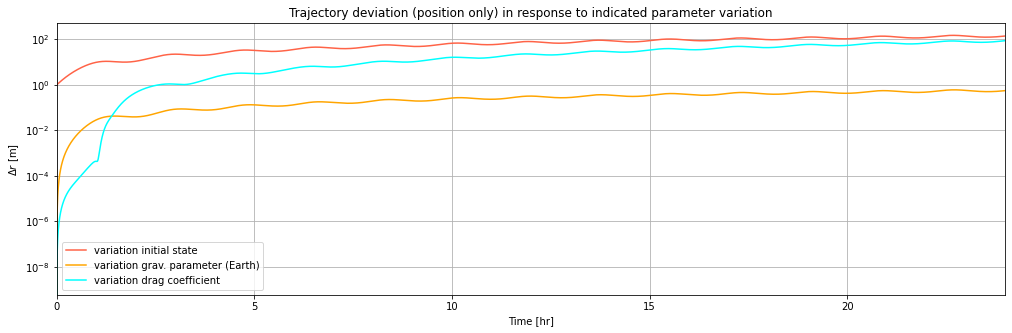

In [14]:
# Plot deviations of position
plt.figure(figsize=(17, 5))
plt.title('Trajectory deviation (position only) in response to indicated parameter variation')
plt.grid()
plt.plot(time_hours, delta_r1, color='tomato', label='variation initial state')
plt.plot(time_hours, delta_r2, color='orange', label='variation grav. parameter (Earth)')
plt.plot(time_hours, delta_r3, color='cyan', label='variation drag coefficient')
plt.yscale('log')
plt.xlabel('Time [hr]')
plt.ylabel('$\Delta r$ [m]')
plt.xlim([min(time_hours), max(time_hours)])
plt.legend()

### Plot the deviation in velocity
Make a plot of the deivation in velocity over time, in response to all parameter variations.

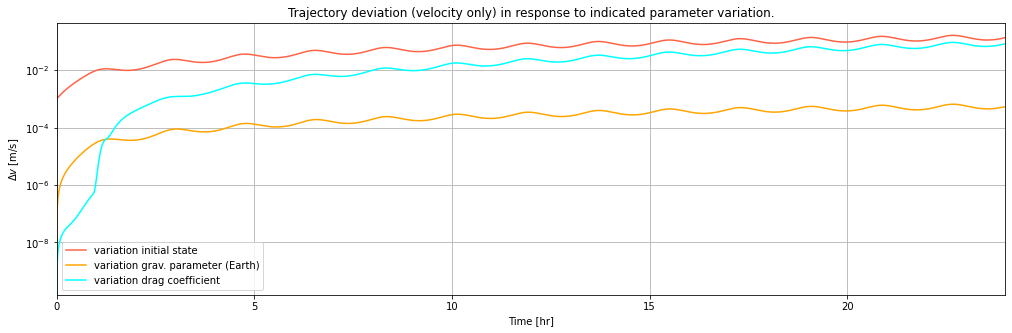

In [15]:
# Plot deviations of speed
plt.figure(figsize=(17, 5))
plt.title('Trajectory deviation (velocity only) in response to indicated parameter variation.')
plt.grid()
plt.plot(time_hours, delta_v1, color='tomato', label='variation initial state')
plt.plot(time_hours, delta_v2, color='orange', label='variation grav. parameter (Earth)')
plt.plot(time_hours, delta_v3, color='cyan', label='variation drag coefficient')
plt.yscale('log')
plt.xlabel('Time [hr]')
plt.ylabel('$\Delta v$ [m/s]')
plt.xlim([min(time_hours), max(time_hours)])
plt.legend()